In [1]:
#Import Libraries

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow
keras = tensorflow.keras
from tensorflow.keras import layers, Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 
import time
import sys
from keras.preprocessing import image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import pandas as pd
import pathlib

pd.set_option("display.precision", 8)
data = pathlib.Path('Images/') 
data_root = 'Images/'

In [2]:
# Create a data generator for traning and val (splitting)

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR, 
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

# Below, first line is the splitted test fraction (20%)
# Second line is splitted train set fraction (80%)

Images/
Found 48 images belonging to 12 classes.
Found 192 images belonging to 12 classes.


In [3]:
image_batch_train, label_batch_train = next(iter(train_generator))  
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print("These are the Classes of Images used: \n", dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 12)
These are the Classes of Images used: 
 ['Abs System' 'Airbag Srs' 'Battery Charge' 'Brake System' 'Check Engine'
 'Diesel Particulate Filter' 'Electric Power Steering'
 'High Engine Coolant Temperature' 'Low Fuel' 'Master System Warning'
 'Oil Pressure' 'Tyre Pressure']


In [4]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/3",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                15372     
Total params: 2,273,356
Trainable params: 15,372
Non-trainable params: 2,257,984
_________________________________________________________________


In [5]:
start = time.time() #To document time
    
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1, 
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

elapsed_time = float(time.time() - start)
print("Time used for training is: \n",str(elapsed_time)[0:5],"s")


# Check the training Below, You'll find following per epoch:
# Time per epoch in seconds
# Training loss as 'loss'
# training accuracy as 'acc'
# Validation loss as 'val_loss'
# Validation accuracy as 'val_acc'


Epoch 1/10
6/6 [==============================] - 22s 2s/step - loss: 3.0149 - acc: 0.0677 - val_loss: 2.2883 - val_acc: 0.2708
Epoch 2/10
6/6 [==============================] - 13s 2s/step - loss: 2.1946 - acc: 0.2760 - val_loss: 1.7241 - val_acc: 0.4167

In [6]:
CARS_SAVED_MODEL = "saved_models/cars"
model.save(CARS_SAVED_MODEL) #save model 

# reload model 
cars_model = keras.models.load_model(CARS_SAVED_MODEL, custom_objects={'KerasLayer':hub.KerasLayer} )

INFO:tensorflow:Assets written to: saved_models/cars\assets


INFO:tensorflow:Assets written to: saved_models/cars\assets


In [7]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [8]:
tf_model_predictions = cars_model.predict(val_image_batch)
tf_model_predictions[1]

array([3.3563698e-05, 6.8294513e-04, 1.8615496e-03, 9.0667112e-05,
       1.0748955e-03, 3.1105892e-03, 7.1980455e-04, 9.7550505e-01,
       1.8336645e-03, 9.1796211e-04, 1.3652913e-02, 5.1633402e-04],
      dtype=float32)

In [9]:
# Getting class with the highest probability
print(dataset_labels[np.argmax(tf_model_predictions[1])])

High Engine Coolant Temperature


In [10]:
# Testing Model

tf_model_predictions = cars_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Abs System,Airbag Srs,Battery Charge,Brake System,Check Engine,Diesel Particulate Filter,Electric Power Steering,High Engine Coolant Temperature,Low Fuel,Master System Warning,Oil Pressure,Tyre Pressure
0,0.00044655,0.00005335,0.00078203,0.00025975,0.94709551,0.01401875,0.00020057,0.00106143,0.01180652,0.00057688,0.00216890,0.02152975
1,0.00003356,0.00068295,0.00186155,0.00009067,0.00107490,0.00311059,0.00071980,0.97550505,0.00183366,0.00091796,0.01365291,0.00051633
2,0.00566701,0.00681575,0.00451008,0.01046097,0.01381854,0.01583872,0.03581750,0.01375794,0.02276073,0.71596581,0.11795770,0.03662915
3,0.00051840,0.00477980,0.90528977,0.00670129,0.00139823,0.00056769,0.00116259,0.00179034,0.05999668,0.00774864,0.00283430,0.00721222
4,0.55851632,0.00606791,0.00267672,0.21202636,0.00408355,0.04721327,0.09783517,0.00166905,0.03857339,0.00247206,0.00346517,0.02540100


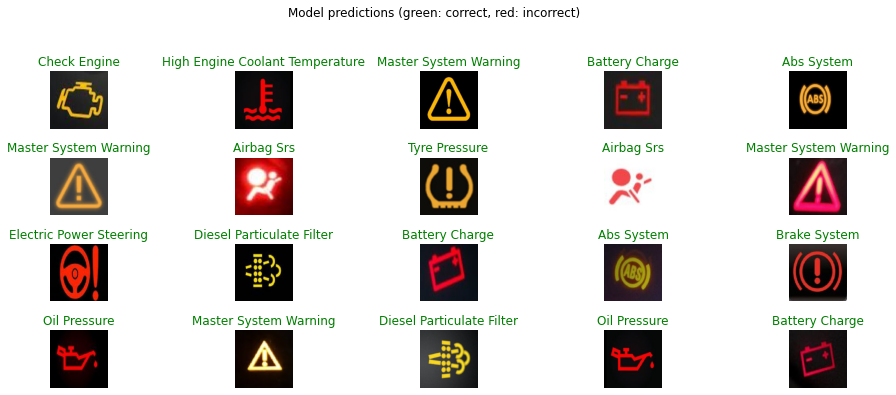

In [11]:
# Print images batch and labels predictions for Metrics on Validation set

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(6,5,n+1)
    plt.imshow(val_image_batch[n])
    color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")